<a href="https://colab.research.google.com/github/Jirtus-sanasam/MLP-Diabetes/blob/main/Diabetes3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier



In [ ]:
df = pd.read_csv('diabetes_data2.csv')
df.head()
df.shape

(768, 9)

In [ ]:
X = df.drop("Outcome", axis=1)
Y = df["Outcome"]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_scaled, y_train)

In [ ]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(x_train_resampled, y_train_resampled)
important_features = np.argsort(mi)[::-1][:10]
mi_scores = pd.Series(mi, index=X.columns[important_features])
mi_rank = mi_scores.rank(ascending=False, method='min')
print(mi_scores)


Age                         0.156875
Glucose                     0.160825
Pregnancies                 0.109874
BloodPressure               0.079536
BMI                         0.057869
SkinThickness               0.081695
Insulin                     0.056202
DiabetesPedigreeFunction    0.168230
dtype: float64


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier



In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rfe = RFE(estimator=rf, n_features_to_select=5)
rfe.fit(x_train_resampled, y_train_resampled)

selected_rfe = X.columns[rfe.support_].tolist()
print(selected_rfe)

['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [ ]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# L1-regularized Logistic Regression
l1_model = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42)
l1_model.fit(x_train_resampled, y_train_resampled)

# Coefficients
coefs = np.abs(l1_model.coef_).ravel()
selected_l1 = X.columns[coefs > 1e-6].tolist()  # non-zero coefficients
coef_dict = dict(zip(X.columns, coefs))

print("✅ L1 Selected Features:", selected_l1)
print("\nL1 Coefficients:")
for feature, coef in coef_dict.items():
    print(f"{feature}: {coef:.4f}")


✅ L1 Selected Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

L1 Coefficients:
Pregnancies: 0.2394
Glucose: 1.1022
BloodPressure: 0.2456
SkinThickness: 0.0397
Insulin: 0.1771
BMI: 0.9027
DiabetesPedigreeFunction: 0.3002
Age: 0.4714


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fit Random Forest
rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
rf_model.fit(x_train_resampled, y_train_resampled)

# Feature importances
importances = rf_model.feature_importances_
importance_df = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Select top 10 features
selected_tree = importance_df.head(10).index.tolist()

print("✅ Tree-based Selected Features:", selected_tree)
print("\nFeature Importances:")
for feature, score in importance_df.items():
    print(f"{feature}: {score:.4f}")


✅ Tree-based Selected Features: ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin']

Feature Importances:
Glucose: 0.2395
BMI: 0.1836
Age: 0.1615
DiabetesPedigreeFunction: 0.1119
Pregnancies: 0.0841
BloodPressure: 0.0837
SkinThickness: 0.0680
Insulin: 0.0676


In [ ]:
final_features = list(set(selected_l1) & set(selected_tree) & set(selected_rfe) & set(mi_scores.index))
print("✅ Final Selected Features:", final_features)



✅ Final Selected Features: ['DiabetesPedigreeFunction', 'Glucose', 'BloodPressure', 'Age', 'BMI']


In [ ]:
# Convert scaled NumPy arrays back to DataFrames to preserve column names
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=X.columns)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=X.columns)

# Step 1: Keep only the selected features
x_train_resampled_fs = x_train_scaled_df[final_features]
x_test_fs = x_test_scaled_df[final_features]  # Make sure your test set is scaled similarly

In [ ]:
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_scaled, y_train)
x_train_resampled_fs = x_train_scaled_df[final_features]


In [ ]:
# -----------------------------
# Step 1: Prepare resampled data with selected features
# -----------------------------
# Convert resampled X back to DataFrame
x_train_resampled_df = pd.DataFrame(x_train_resampled, columns=X.columns)

# Keep only the selected features
x_train_resampled_fs = x_train_resampled_df[final_features]

# Test set scaled DataFrame (already done)
x_test_fs = x_test_scaled_df[final_features]

# -----------------------------
# Step 2: Define baseline MLP
# -----------------------------
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # baseline architecture
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42
)

# -----------------------------
# Step 3: Train MLP on resampled training data
# -----------------------------
mlp.fit(x_train_resampled_fs, y_train_resampled)

# -----------------------------
# Step 4: Predict on test set
# -----------------------------
y_pred_mlp = mlp.predict(x_test_fs)

# -----------------------------
# Step 5: Evaluate performance
# -----------------------------
mlp_results = {
    "Accuracy": accuracy_score(y_test, y_pred_mlp),
    "Precision": precision_score(y_test, y_pred_mlp),
    "Recall": recall_score(y_test, y_pred_mlp),
    "F1 Score": f1_score(y_test, y_pred_mlp)
}

print("Baseline MLP Results:")
print(mlp_results)


Baseline MLP Results:
{'Accuracy': 0.6883116883116883, 'Precision': 0.5432098765432098, 'Recall': 0.8, 'F1 Score': 0.6470588235294118}


In [ ]:
# Step 0: Install DEAP if not already installed
# !pip install deap

import numpy as np
import random
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# -----------------------------
# Step 1: Define the search space
# -----------------------------
activation_options = ['relu', 'tanh']
hidden_layer_options = [(32,), (64,), (64, 32), (128, 64, 32)]
alpha_options = [0.0001, 0.001, 0.01]
learning_rate_init_options = [0.001, 0.01, 0.1]

# -----------------------------
# Step 2: Define fitness function
# -----------------------------
def evaluate(individual):
    # Decode individual
    hidden_layer = hidden_layer_options[individual[0]]
    activation = activation_options[individual[1]]
    alpha = alpha_options[individual[2]]
    lr_init = learning_rate_init_options[individual[3]]

    # Create MLP with these hyperparameters
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer,
        activation=activation,
        solver='adam',
        alpha=alpha,
        learning_rate='adaptive',
        learning_rate_init=lr_init,
        max_iter=500,
        random_state=42
    )

    # 5-fold cross-validation on resampled training data
    scores = cross_val_score(mlp, x_train_resampled_fs, y_train_resampled, cv=5, scoring='f1')
    return (scores.mean(),)  # DEAP expects a tuple

# -----------------------------
# Step 3: Setup GA with DEAP
# -----------------------------
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # maximize F1
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Gene encoding: indexes for options
toolbox.register("attr_hidden", random.randint, 0, len(hidden_layer_options)-1)
toolbox.register("attr_activation", random.randint, 0, len(activation_options)-1)
toolbox.register("attr_alpha", random.randint, 0, len(alpha_options)-1)
toolbox.register("attr_lr", random.randint, 0, len(learning_rate_init_options)-1)

# Individual & population
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_hidden, toolbox.attr_activation, toolbox.attr_alpha, toolbox.attr_lr), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Operators
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[0,0,0,0], up=[len(hidden_layer_options)-1, len(activation_options)-1, len(alpha_options)-1, len(learning_rate_init_options)-1], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# -----------------------------
# Step 4: Run the GA
# -----------------------------
population = toolbox.population(n=20)
NGEN = 10  # number of generations
CXPB, MUTPB = 0.7, 0.2

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# -----------------------------
# Step 5: Get the best individual
# -----------------------------
best_ind = tools.selBest(population, 1)[0]
print("Best individual:", best_ind)

best_hyperparams = {
    "hidden_layer_sizes": hidden_layer_options[best_ind[0]],
    "activation": activation_options[best_ind[1]],
    "alpha": alpha_options[best_ind[2]],
    "learning_rate_init": learning_rate_init_options[best_ind[3]]
}
print("Best Hyperparameters:", best_hyperparams)

# -----------------------------
# Step 6: Train MLP with best GA parameters
# -----------------------------
best_mlp = MLPClassifier(
    hidden_layer_sizes=best_hyperparams['hidden_layer_sizes'],
    activation=best_hyperparams['activation'],
    solver='adam',
    alpha=best_hyperparams['alpha'],
    learning_rate='adaptive',
    learning_rate_init=best_hyperparams['learning_rate_init'],
    max_iter=500,
    random_state=42
)

best_mlp.fit(x_train_resampled_fs, y_train_resampled)

# -----------------------------
# Step 7: Evaluate on test set
# -----------------------------
y_pred_ga_mlp = best_mlp.predict(x_test_fs)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
ga_mlp_results = {
    "Accuracy": accuracy_score(y_test, y_pred_ga_mlp),
    "Precision": precision_score(y_test, y_pred_ga_mlp),
    "Recall": recall_score(y_test, y_pred_ga_mlp),
    "F1 Score": f1_score(y_test, y_pred_ga_mlp)
}

print("GA-Optimized MLP Results:")
print(ga_mlp_results)



/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimizati

Best individual: [2, 0, 1, 2]
Best Hyperparameters: {'hidden_layer_sizes': (64, 32), 'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.1}
GA-Optimized MLP Results:
{'Accuracy': 0.6948051948051948, 'Precision': 0.5512820512820513, 'Recall': 0.7818181818181819, 'F1 Score': 0.6466165413533834}


In [ ]:
!pip install deap

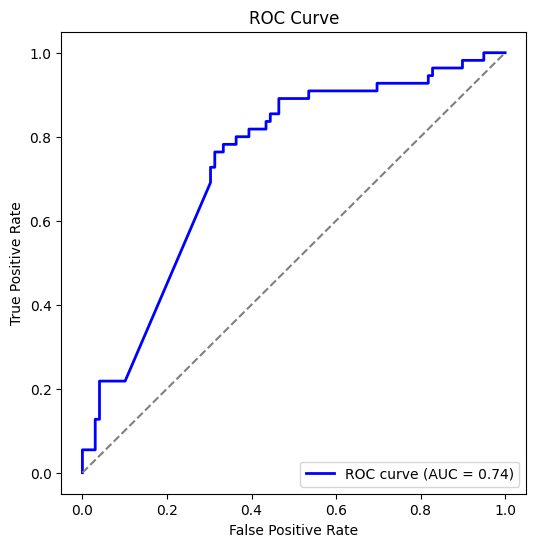

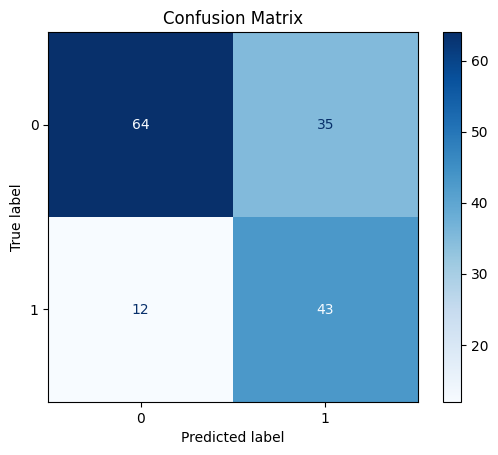

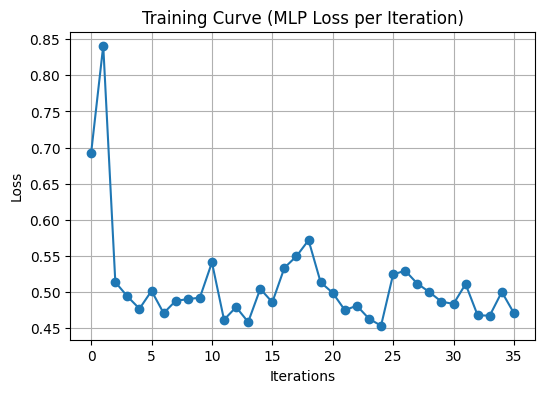

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# -----------------------------
# 1️⃣ ROC Curve
# -----------------------------
y_proba = best_mlp.predict_proba(x_test_fs)[:, 1]  # probability for class 1
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# -----------------------------
# 2️⃣ Confusion Matrix
# -----------------------------
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ga_mlp, cmap='Blues', display_labels=[0,1])
plt.title('Confusion Matrix')
plt.show()

# -----------------------------
# 3️⃣ Training Curve
# -----------------------------
plt.figure(figsize=(6,4))
plt.plot(best_mlp.loss_curve_, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Curve (MLP Loss per Iteration)')
plt.grid(True)
plt.show()
